In [1]:
%cd ..

/root/huy/BrainSegmentation


In [2]:
import os
from pprint import pprint
import mlflow.pytorch
os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/huytrnq/BrainSegmentation.mlflow"
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt


import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from utils.loss import DiceLoss, DiceCrossEntropyLoss
from utils.dataset import BrainMRISliceDataset

from utils.utils import train, validate, evaluate_segmentation
from utils.predict import Predictor
from utils.metric import MetricsMonitor, dice_coefficient, dice_score_3d, hausdorff_distance, average_volumetric_difference

from utils.vis import plot_images
from utils.transforms import RobustZNormalization

/root/miniconda3/envs/py11/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Constants

In [39]:
ROOT_DIR = './Data/'
BATCH_SIZE = 16
NUM_CLASSES = 4
EPOCHS = 300
DEVICE = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 0
LR = 0.01
N_TEST = 5

## Transforms

In [4]:
train_transform = A.Compose([
    # Normalize and convert to tensors
    A.Normalize(mean=(0,), std=(1,), max_pixel_value=1.0, p=1.0),
    RobustZNormalization(),
    ToTensorV2()
], additional_targets={'mask': 'mask'})  # Include mask augmentation

test_transform = A.Compose([
        A.Normalize(mean=(0,), std=(1,), max_pixel_value=1.0, p=1.0),
        RobustZNormalization(),
        ToTensorV2()
], additional_targets={'mask': 'mask'})

In [15]:
train_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'train'), slice_axis=2, transform=train_transform, cache=True, ignore_background=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=2, transform=test_transform, cache=True, ignore_background=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

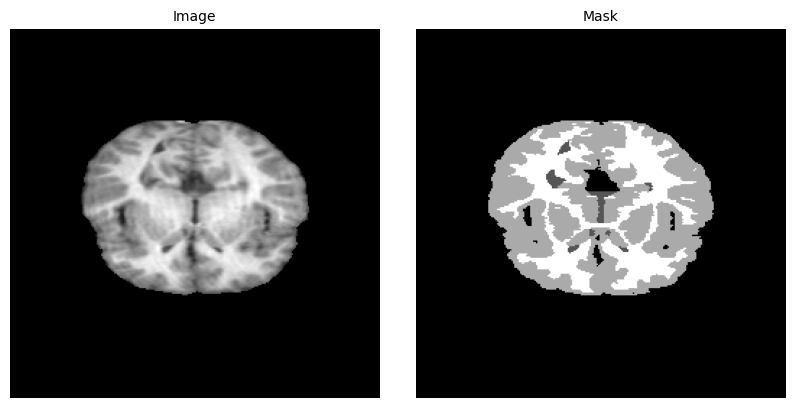

In [16]:
image, mask, volume_idx, slice_idx = train_dataset[129]


plot_images([image.permute(2, 1, 0).numpy(), mask.permute(2, 1, 0).numpy()] , ['Image', 'Mask'], cols=2, figsize=(10, 5))

## Models

In [18]:
model = smp.Unet(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=NUM_CLASSES,                      # model output channels (number of classes in your dataset)
)

model = model.to(DEVICE)

## Loss & Optimizer

In [19]:
criterion = DiceCrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

## Training

In [20]:
# Monitors
train_monitor = MetricsMonitor(metrics=["loss", "dice_score"])
val_monitor = MetricsMonitor(
    metrics=["loss", "dice_score"], patience=5, mode="max"
)
test_monitor = MetricsMonitor(metrics=["loss", "dice_score"])

In [ ]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    train(model, train_loader, criterion, optimizer, DEVICE, train_monitor)
    scheduler.step()
    validate(model, val_loader, criterion, DEVICE, val_monitor)

In [ ]:
## Export Model
torch.save(model.state_dict(), "model.pth")

## Predict

### Load model

In [17]:
logged_model = 'runs:/b825a297281a465ea908e1364f6074d6/model'

# Load the model
model = mlflow.pytorch.load_model(logged_model, map_location=DEVICE)

In [18]:
predictions = []
labels = []
volume_idxs = []
slice_idxs = []
meta_data = val_dataset.metadata

model.eval()
with torch.no_grad():
    for batch_idx, (images, masks, volume_idx, slice_idx) in enumerate(val_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)
        predictions.append(outputs)
        labels.append(masks)
        volume_idxs.extend(volume_idx.numpy().tolist())
        slice_idxs.extend(slice_idx.numpy().tolist())
        
predictions = torch.cat(predictions, dim=0).detach().cpu()
labels = torch.cat(labels, dim=0).squeeze(1).long().detach().cpu()
dice_scores = dice_coefficient(predictions, labels, num_classes=4)
print(dice_scores)
print(f"Dice Score: {np.mean(dice_scores)}")

[0.9955854415893555, 0.8991853594779968, 0.8881125450134277, 0.8790041208267212]
Dice Score: 0.9154718667268753


In [10]:
predictions = torch.softmax(predictions.float(), dim=1).cpu().numpy()
predictions = np.argmax(predictions, axis=1)

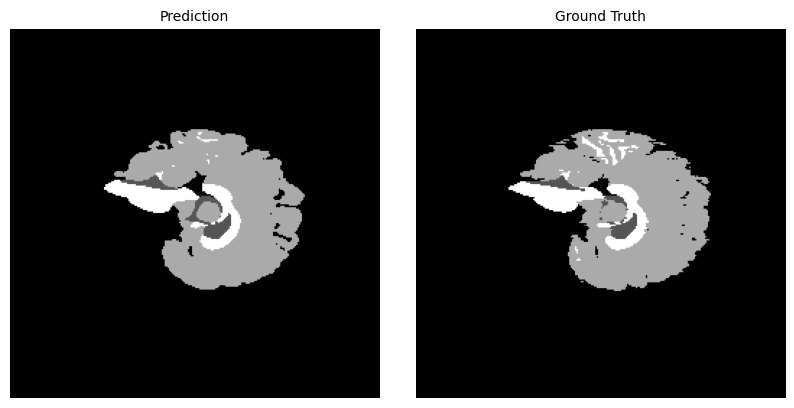

In [11]:
plot_images([predictions[129, :, :], labels[129, :, :].cpu().numpy()], ["Prediction", "Ground Truth"], cols=2)

## Ensemble

### Axial

In [50]:
axial_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=0, transform=test_transform, cache=True, ignore_background=False)
axial_loader = DataLoader(axial_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
axial_labels = torch.cat([mask for _, mask, _, _ in axial_loader], dim=0).squeeze(1).reshape(N_TEST, -1, 128, 256)

In [44]:
axial_predictor = Predictor(mlflow_model_uri="runs:/bb8ff770bd7f495e9151a575eda3624a/model", device=DEVICE)
axial_probs = axial_predictor.predice_slices(axial_loader, proba=True, plane='axial')

In [ ]:
axial_predictions = torch.argmax(axial_probs, axis=1)
axial_r_dict = evaluate_segmentation(axial_predictions, axial_labels, NUM_CLASSES, include_background=True)

Dice scores: {0: 0.9969872236251831, 1: 0.8978163003921509, 2: 0.9276361465454102, 3: 0.9195453524589539}
Mean Dice score: 0.914999266465505
Hausdorff Distances: {0: 17.615633010864258, 1: 21.235445022583008, 2: 8.58439826965332, 3: 7.8490705490112305}
Mean Hausdorff Distance: 12.556304613749186
Average Volumetric Differences: {0: 0.0005928487479701718, 1: 0.024134284958708247, 2: 0.0014454269661736447, 3: 0.016263814235689275}
Mean Average Volumetric Difference: 0.013947842053523722


{'Dice': {0: 0.9969872236251831,
  1: 0.8978163003921509,
  2: 0.9276361465454102,
  3: 0.9195453524589539},
 'Mean Dice': 0.914999266465505,
 'Hausdorff Distances': {0: 17.615633010864258,
  1: 21.235445022583008,
  2: 8.58439826965332,
  3: 7.8490705490112305},
 'Mean Hausdorff Distance': 12.556304613749186,
 'Average Volumetric Differences': {0: 0.0005928487479701718,
  1: 0.024134284958708247,
  2: 0.0014454269661736447,
  3: 0.016263814235689275},
 'Mean Average Volumetric Difference': 0.013947842053523722}

### Coronal

In [56]:
coronal_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=1, transform=test_transform, cache=True, ignore_background=False)
coronal_loader = DataLoader(coronal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
coronal_labels = torch.cat([mask for _, mask, _, _ in coronal_loader], dim=0).squeeze(1).reshape(N_TEST, -1, 256, 256).permute(0, 2, 1, 3)

In [54]:
coronal_predictor = Predictor(mlflow_model_uri="runs:/e05a0eacc46146c9a56e70a185e35eed/model", device=DEVICE)
coronal_probs = coronal_predictor.predice_slices(coronal_loader, proba=True, plane='coronal')

In [57]:
coronal_predictions = torch.argmax(coronal_probs, axis=1)
coronal_r_dict = evaluate_segmentation(coronal_predictions, coronal_labels, NUM_CLASSES, include_background=True)

Dice scores: {0: 0.9960435628890991, 1: 0.8671377897262573, 2: 0.901528000831604, 3: 0.915066123008728}
Mean Dice score: 0.8945773045221964
Hausdorff Distances: {0: 23.98398208618164, 1: 24.506206512451172, 2: 23.834346771240234, 3: 22.106098175048828}
Mean Hausdorff Distance: 23.48221715291341
Average Volumetric Differences: {0: 0.002014608879852536, 1: 0.023288395453036105, 2: 0.0030044657984249976, 3: 0.048923345276552545}
Mean Average Volumetric Difference: 0.025072068842671213


### Sagittal

In [58]:
sagittal_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=2, transform=test_transform, cache=True, ignore_background=False)
sagittal_loader = DataLoader(sagittal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
sagittal_labels = torch.cat([mask for _, mask, _, _ in sagittal_loader], dim=0).squeeze(1).reshape(N_TEST, -1, 256, 128).permute(0, 2, 3, 1)

In [59]:
sagittal_predictor = Predictor(mlflow_model_uri="runs:/bdc118531a4a4e0fb4ffa9dc8fb0d83d/model", device=DEVICE)
sagittal_probs = sagittal_predictor.predice_slices(sagittal_loader, proba=True, plane='sagittal')

In [60]:
sagittal_predictions = torch.argmax(sagittal_probs, axis=1)
sagittal_r_dict = evaluate_segmentation(sagittal_predictions, sagittal_labels, NUM_CLASSES, include_background=True)

Dice scores: {0: 0.9969256520271301, 1: 0.9059034585952759, 2: 0.9269552230834961, 3: 0.9172420501708984}
Mean Dice score: 0.9167002439498901
Hausdorff Distances: {0: 16.87217140197754, 1: 23.61018943786621, 2: 12.401985168457031, 3: 9.574711799621582}
Mean Hausdorff Distance: 15.195628801981607
Average Volumetric Differences: {0: 0.0002687785066404808, 1: 0.03166798836860074, 2: 0.013846446178220707, 3: 0.034669908134389006}
Mean Average Volumetric Difference: 0.02672811422707015


### Ensemble

In [62]:
ensemble_probs = (axial_probs + coronal_probs + sagittal_probs) / 3
ensemble_predictions = torch.argmax(ensemble_probs, dim=1)
labels = axial_labels

In [63]:
ensemble_r_dict = evaluate_segmentation(ensemble_predictions, labels, NUM_CLASSES, include_background=True)

Dice scores: {0: 0.9975493550300598, 1: 0.9201601147651672, 2: 0.9435482025146484, 3: 0.9394735097885132}
Mean Dice score: 0.9343939423561096
Hausdorff Distances: {0: 17.761503219604492, 1: 11.132668495178223, 2: 9.03249740600586, 3: 7.8488569259643555}
Mean Hausdorff Distance: 9.338007609049479
Average Volumetric Differences: {0: 0.0003300011886492948, 1: 0.000978059740933412, 2: 0.004361559538723224, 3: 0.015637277030636852}
Mean Average Volumetric Difference: 0.006992298770097829
